<a href="https://colab.research.google.com/github/yweslakarep123/decision_treeID3/blob/main/TUGAS_DECISION_TREE_ID3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris

# Memuat dataset Iris
iris = load_iris()

# Membuat DataFrame dari data dan menambahkan nama kolom
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Menambahkan kolom target (spesies)
iris_df['Species'] = iris.target_names[iris.target]

# Menyimpan DataFrame sebagai file CSV di Colab
iris_df.to_csv('/content/iris_dataset.csv', index=False)

# Membaca dan menampilkan file CSV
df = pd.read_csv('/content/iris_dataset.csv')
print(df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  Species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


In [5]:
import math

In [6]:
import numpy as np
from graphviz import Digraph
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Fitur yang digunakan untuk memisahkan node
        self.threshold = threshold  # Ambang batas pemisahan node
        self.left = left  # Anak kiri dari node
        self.right = right  # Anak kanan dari node
        self.value = value  # Nilai prediksi jika node adalah leaf node

class DecisionTreeID3:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # Maksimal kedalaman pohon

    # def _entropy(self, y):
    #     # Hitung entropi dari kelas target
    #     classes, counts = np.unique(y, return_counts=True)
    #     probs = counts / len(y)
    #     entropy = -np.sum(probs * np.log2(probs))
    #     return entropy

    def _entropy(self, y):
    # Hitung entropi dari kelas target
      unique_classes = set(y)
      entropy = 0
      total_samples = len(y)
      for cls in unique_classes:
          class_count = sum(1 for label in y if label == cls)
          class_prob = class_count / total_samples
          entropy -= class_prob * math.log2(class_prob)
      return entropy


    def _information_gain(self, X, y, feature, threshold):
        # Hitung gain informasi untuk suatu fitur dan ambang tertentu
        left_indices = X[:, feature] <= threshold
        right_indices = ~left_indices
        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])
        n = len(y)
        left_weight = sum(left_indices) / n
        right_weight = sum(right_indices) / n
        gain = self._entropy(y) - (left_weight * left_entropy + right_weight * right_entropy)
        return gain

    def _find_best_split(self, X, y):
        # Temukan pemisahan terbaik untuk setiap fitur
        best_gain = 0
        best_feature = None
        best_threshold = None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        # Rekursif membangun pohon keputusan
        if depth == 0 or len(np.unique(y)) == 1:
            # Jika sudah mencapai maksimal kedalaman atau semua sampel memiliki label yang sama
            value = np.argmax(np.bincount(y))
            return Node(value=value)

        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            # Jika tidak ada pemisahan yang ditemukan (mungkin semua nilai fitur sama)
            value = np.argmax(np.bincount(y))
            return Node(value=value)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_child = self._build_tree(X[left_indices], y[left_indices], depth - 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth - 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        # Membangun pohon keputusan dari data latih
        self.root = self._build_tree(X, y, self.max_depth)

    ########## RECURSIVE METHODE ##########
    # def _predict(self, x, node):
    #     # Rekursif untuk melakukan prediksi
    #     if node.value is not None:
    #         return node.value
    #     if x[node.feature] <= node.threshold:
    #         return self._predict(x, node.left)
    #     else:
    #         return self._predict(x, node.right)

    ########## ITERATIVE METHODE ##########
    def _predict(self, x, node):
        # Mulai dari root node
        current_node = self.root
        while True:
            # Jika node adalah leaf node, kembalikan nilai prediksi
            if current_node.value is not None:
                return current_node.value
            # Jika fitur dari sampel kurang dari atau sama dengan ambang batas node saat ini,
            # pindah ke anak kiri
            if x[current_node.feature] <= current_node.threshold:
                current_node = current_node.left
            # Jika fitur dari sampel lebih besar dari ambang batas node saat ini,
            # pindah ke anak kanan
            else:
                current_node = current_node.right


    def predict(self, X):
        # Prediksi label kelas untuk setiap sampel dalam X
        return [self._predict(x, self.root) for x in X]

    def _to_dot(self, node, dot):
            if node is None:
                return

            dot.node(str(id(node)), label=f"Feature: {node.feature}\nThreshold: {node.threshold}\nValue: {node.value}")

            if node.left is not None:
                dot.edge(str(id(node)), str(id(node.left)), label="<= Threshold")

            if node.right is not None:
                dot.edge(str(id(node)), str(id(node.right)), label="> Threshold")

            self._to_dot(node.left, dot)
            self._to_dot(node.right, dot)

    def display_tree(self):
        dot = Digraph()
        self._to_dot(self.root, dot)
        dot.render('decision_tree', format='png', cleanup=True)
        dot.view()


In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Memuat dataset Iris
iris = load_iris()
X = iris.data
y = iris.target

# Bagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan latih model DecisionTreeID3
model = DecisionTreeID3(max_depth=3)
model.fit(X_train, y_train)
# model.display_tree()

# Lakukan prediksi pada data uji
y_pred = model.predict(X_test)

# Hitung akurasi prediksi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


0.9583333333333334
1.0


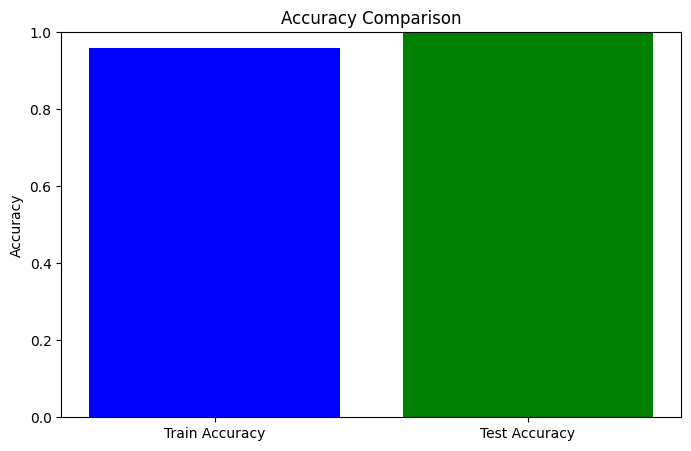

In [8]:
import matplotlib.pyplot as plt

# Akurasi data latih dan data uji
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(train_accuracy)
print(test_accuracy)
# Membuat bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.ylim(0, 1)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pickle

# Misalkan model Anda disimpan dalam variabel 'model'
model_path = '/content/modelID3.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)


<h1>PENJELASAN KODE</h1>

<h2>INISIASI NODE TREE</h2>
<p> pada awal algoritma kita harus membuat class yang berisi bagian dari tree untuk digunakan dalam pembuatan tree</p>

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Fitur yang digunakan untuk memisahkan node
        self.threshold = threshold  # Ambang batas pemisahan node
        self.left = left  # Anak kiri dari node
        self.right = right  # Anak kanan dari node
        self.value = value  # Nilai prediksi jika node adalah leaf node

In [ ]:
# Membuat instansi dari kelas Node
node = Node(feature='Sepal Length', threshold=5.0, left=None, right=None, value='Setosa')

# Mengakses atribut dari instansi Node
print("Feature:", node.feature)
print("Threshold:", node.threshold)
print("Left child:", node.left)
print("Right child:", node.right)
print("Value:", node.value)

Feature: Sepal Length
Threshold: 5.0
Left child: None
Right child: None
Value: Setosa


<p>NOTE: kita bisa mengambil variabel di dalam metode suatu kelas untuk dipakai di kelas lain dengan membuat objek kelas tersebut</p>

<h2>INISIASI VARIABEL KEDALAMAN MAXIMAL POHON</h2>
<p>Lalu pada kelas lain kita buat kelas baru untuk model kita yang bernama DecisionTreeID3, model ini akan mengambil variabekl dari kelas Node untuk dikembangkan menjadi suatu algoritma.

metode pertama kelas ini kita gunkana untuk menginsiasi kedalaman tree yang dibutuhkan untuk memecahkan masalah</p>

In [ ]:
class DecisionTreeID3:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # Maksimal kedalaman pohon

In [ ]:
dc_tree = DecisionTreeID3(10)
print(dc_tree.max_depth)

10


<h2>KALKULASI ENTROPY SUATU DATA</h2>
<p>Entropy bisa dikatakan sebagai kebutuhan bit untuk menyatakan suatu kelas. Semakin  kecil nilai Entropy maka semakin baik untuk digunakan dalam mengekstraksi suatu  kelas.

Dalam code ini, kita gunakan fungsi numpy untuk menghitung entropy target data yang kita masukkan </p>

In [10]:
# def _entropy(y):
#     # Hitung entropi dari kelas target
#     classes, counts = np.unique(y, return_counts=True)
#     probs = counts / len(y)
#     entropy = -np.sum(probs * np.log2(probs))
#     return entropy

def _entropy(y):
  # Hitung entropi dari kelas target
  unique_classes = set(y)
  entropy = 0
  total_samples = len(y)
  for cls in unique_classes:
    class_count = sum(1 for label in y if label == cls)
    class_prob = class_count / total_samples
    entropy -= class_prob * math.log2(class_prob)
  return entropy

print(_entropy('setosa'))
print(_entropy('versicolor'))
print(_entropy('virginica'))

2.2516291673878226
2.9219280948873623
2.6416041678685933


<h2>INFORMASI YANG DI GAIN HASIL ENTROPY</h2>
<p>gain informasi adalah salah satu teknik yang ada di decision tree yang digunakan untuk pemilihan suatu atribut.

Information Gain: pengurangan entropy disebabkan oleh partisi berdasarkan  suatu atribut.


Semakin besar info gain = atribut itu semakin membuat homogen = semakin  bagus

didalam code, kami menggunakan hasil entorpy, threshold, dan fitur untuk untuk mencari gain yang terbaik. Gain terbaik tersebut kita juga gunakan untuk mencari fitur dan threshold terbaik juga</p>

In [ ]:
def _information_gain(X, y, feature, threshold):
    # Hitung gain informasi untuk suatu fitur dan ambang tertentu
    left_indices = X[:, feature] <= threshold
    right_indices = ~left_indices
    left_entropy = _entropy(y[left_indices])
    right_entropy = _entropy(y[right_indices])
    n = len(y)
    left_weight = sum(left_indices) / n
    right_weight = sum(right_indices) / n
    gain = _entropy(y) - (left_weight * left_entropy + right_weight * right_entropy)
    return gain


In [ ]:
X_train = np.array([[5, 7, 3.2, 1.2, 0.4],
                    [5, 2, 3.3, 1.4, 0.5],
                    [6.3, 4.4, 1.5, 1.6, 0.6],
                    [4.9, 4.1, 1.6, 0.7, 0.7],
                    [5, 3.6, 1.7, 0.8, 0.8]])
y_train = np.array([0, 0, 1, 1, 1])  # Contoh label kelas untuk data latih

# Contoh pemanggilan _information_gain dengan data latih contoh
feature = 2  # Pilih fitur ke-0
threshold = 1.9  # Contoh ambang batas
gain = _information_gain(X_train, y_train, feature, threshold)
print("Information Gain:", gain)


Information Gain: 0.9709505944546686


<h2>MEMISAH DAN MENCARI NILAI YANG TERBAIK</h2>
<p> metode ini digunakan untuk mengoptimasi algoritam tree kita dengan mencari gain terabik, fitur terbaik, dan threshold terbaik di code kita</p>

In [ ]:
def _find_best_split(X, y):
  # Temukan pemisahan terbaik untuk setiap fitur
  best_gain = 0
  best_feature = None
  best_threshold = None
  for feature in range(X.shape[1]):
    thresholds = np.unique(X[:, feature])
    for threshold in thresholds:
      gain = _information_gain(X, y, feature, threshold)
      if gain > best_gain:
        best_gain = gain
        best_feature = feature
        best_threshold = threshold
  return best_feature, best_threshold



X_train = np.array([[5, 7, 3.2, 1.2, 0.4],
                    [5, 2, 3.3, 1.4, 0.5],
                    [6.3, 4.4, 1.5, 1.6, 0.6],
                    [4.9, 4.1, 1.6, 0.7, 0.7],
                    [5, 3.6, 1.7, 0.8, 0.8]])
y_train = np.array([0, 0, 1, 1, 1])  # Contoh label kelas untuk data latih

print(_find_best_split(X_train, y_train))

(2, 1.7)


<h2>PEMBUATAN ALGORITMA TREE</h2>
<p>Setelah kita mengetahui fitur, threshold, yang terbaik maka kita bisa define berapa node yang kita perlukan di tree kita dan bagaimana struktur kita. Pembuatan tree ini kami gunakan metode rekursif (bisa saja menggunakan iterasi)</p>

In [ ]:
def _build_tree(X, y, depth):
  # Rekursif membangun pohon keputusan
  if depth == 0 or len(np.unique(y)) == 1:
    # Jika sudah mencapai maksimal kedalaman atau semua sampel memiliki label yang sama
    value = np.argmax(np.bincount(y))
    return Node(value=value)

  best_feature, best_threshold = _find_best_split(X, y)
  if best_feature is None:
    # Jika tidak ada pemisahan yang ditemukan (mungkin semua nilai fitur sama)
    value = np.argmax(np.bincount(y))
    return Node(value=value)

  left_indices = X[:, best_feature] <= best_threshold
  right_indices = ~left_indices
  left_child = _build_tree(X[left_indices], y[left_indices], depth - 1)
  right_child = _build_tree(X[right_indices], y[right_indices], depth - 1)

  return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

X_train = np.array([[5, 7, 3.2, 1.2, 0.4],
                    [5, 2, 3.3, 1.4, 0.5],
                    [6.3, 4.4, 1.5, 1.6, 0.6],
                    [4.9, 4.1, 1.6, 0.7, 0.7],
                    [5, 3.6, 1.7, 0.8, 0.8]])
y_train = np.array([0, 0, 1, 1, 1])  # Contoh label kelas untuk data latih
depth = 2
print(_build_tree(X_train, y_train, depth).feature)
print(_build_tree(X_train, y_train, depth).threshold)
print(_build_tree(X_train, y_train, depth).left) # memmory address dimana node kiri di tempatkan
print(_build_tree(X_train, y_train, depth).right) #memmory address dimana node kanan di tempatkan

2
1.7


<h2>FIT DATA KE MODEL</h2>
<p> Dalam kelas tree kita, kita perlu metode untuk memasukkan data kita agar bisa di modelkan. Metode fit ini kita gunakan untuk memasukkan semua data kita agar bisa di proses oleh model</p>

In [ ]:
def fit(X, y, dep):
  # Membangun pohon keputusan dari data latih
  root = _build_tree(X, y, dep)
  return root

X_train = np.array([[5, 7, 3.2, 1.2, 0.4],
                    [5, 2, 3.3, 1.4, 0.5],
                    [6.3, 4.4, 1.5, 1.6, 0.6],
                    [4.9, 4.1, 1.6, 0.7, 0.7],
                    [5, 3.6, 1.7, 0.8, 0.8]])
y_train = np.array([0, 0, 1, 1, 1])  # Contoh label kelas untuk data latih
print(fit(X_train, y_train, 2))

<h2>METODE UNTUK PREDIKSI MODEL</h2>
<p>Akhirnya kita bisa buat metode predict di dalam kelas untuk memprediksi data menggunakan tree yang sudah kita buat</p>

<p> NOTE: sel berikut ini apabila di run akan stuck di loop selesai karena data terbatasi dan tidak ada child nore lanjutan</p>

In [ ]:
def _predict(x, node):
  # Mulai dari root node
  current_node = fit(X_train, y_train, 2)
  while True:
    # Jika node adalah leaf node, kembalikan nilai prediksi
    if current_node.value is not None:
      return current_node.value
      # Jika fitur dari sampel kurang dari atau sama dengan ambang batas node saat ini,
      # pindah ke anak kiri
      if x[current_node.feature] <= current_node.threshold:
        current_node = current_node.left
        # Jika fitur dari sampel lebih besar dari ambang batas node saat ini,
        # pindah ke anak kanan
      else:
        current_node = current_node.right


def predict(X):
  # Prediksi label kelas untuk setiap sampel dalam X
  return [_predict(x, fit(X_train, y_train, 2)) for x in X]



X_test = np.array([[6.5, 3.5, 5.5, 2.5],
                   [5.5, 2.8, 4.5, 1.8]])

print(predict(X_test))

<h3>Dalam kelas tree, terdapat code tambahan untuk mengvisualisasi tree yang telah di buat. Ketika metode tersebut dipanggil. kita akan mendapat file png, pdf dan satu lagi file keterangan yang berberntuk digrapg</h3>

In [ ]:
def _to_dot(node, dot):
  if node is None:
    return

  dot.node(str(id(node)), label=f"Feature: {node.feature}\nThreshold: {node.threshold}\nValue: {node.value}")

  if node.left is not None:
    dot.edge(str(id(node)), str(id(node.left)), label="<= Threshold")

  if node.right is not None:
    dot.edge(str(id(node)), str(id(node.right)), label="> Threshold")

  _to_dot(node.left, dot)
  _to_dot(node.right, dot)

def display_tree():
  dot = Digraph()
  self._to_dot(self.root, dot)
  dot.render('decision_tree', format='png', cleanup=True)
  dot.view()
